# Regression on RBS sequences - Escherichia coli - Predict TIR

This notebook shows the regression of RBS sequences.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - Label
    - One-hot embedding
    - K-mer 
    - PMW (to be added)
    - Unsupervised (to be added)
- Kernels
    - Spectrum
    - Mixed Spectrum
    - Weighted Degree
    - Weighted Degree with Shifting
- Evaluate
    - RMSE score
    - Plot

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels_pairwise import spectrum_kernel_pw, sum_spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, sum_onehot_WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

# A: whole RBS sequence (len: 29)
# B: extracted 20-base RBS seqeunce (A[7:27], len: 20), training features
# C: TIR labels
# D: the design part RBS (B[7:13], len: 6) 

Path = '../data/RBS_seqs.csv'

df = pd.read_csv(Path)
df.columns = ['A', 'B', 'C']
df['D'] = df['B'].str[7:13]
df.head()

,A,B,C,D
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,TTAAGTAAGCGGGGAAAATA,57706,AGCGGG
1,ACGATCTTAAGTAGACGCGGAAAATAATG,TTAAGTAGACGCGGAAAATA,613,GACGCG
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,TTAAGTAAGCGCGGAAAATA,5313,AGCGCG
3,ACGATCTTAAGTAAACGAGGAAAATAATG,TTAAGTAAACGAGGAAAATA,19594,AACGAG
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,TTAAGTAGGCGAGGAAAATA,33626,GGCGAG


In [4]:
# drop the exact same record (same B and C)

df = df.drop_duplicates(subset = ['B', 'C'])
df.shape

(113, 4)

In [5]:
Log_flag = False # indicates whether take log label
Norm_method = 'mean' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization 
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [6]:
# data: num_data * 2, columns: [20-base RBS seq (B), TIR labels (C)]
data = np.asarray(normalize(df)[['B', 'C']])
data.shape

(113, 2)

(array([59., 18., 14.,  5.,  4.,  1.,  5.,  3.,  1.,  3.]),
 array([-0.822402065315266, -0.3868269010770313, 0.0487482631612034,
        0.48432342739943823, 0.9198985916376728, 1.3554737558759076,
        1.7910489201141426, 2.2266240843523772, 2.662199248590612,
        3.0977744128288465, 3.5333495770670806], dtype=object),
 <a list of 10 Patch objects>)

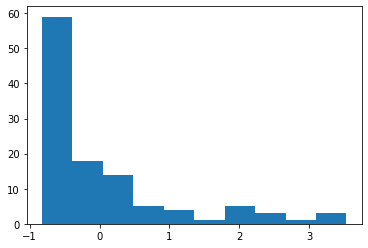

In [7]:
plt.hist(data[:,1])

## Regression

- Kernel Ridge Regression
- Gaussian Process Regression


In [8]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# string kernel list 
# kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]
kernels = [sum_onehot_spectrum_kernel_pw, sum_onehot_WD_kernel_pw]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}
embedding_name = ['onehot', 'kmer', 'label']
kernel_name = {
               spectrum_kernel_pw: 'spec',
               sum_spectrum_kernel_pw: 'sspec',
               sum_onehot_spectrum_kernel_pw: 'sospec',
               mixed_spectrum_kernel_pw: 'mspec',
               WD_kernel_pw: 'WD',
               sum_onehot_WD_kernel_pw: 'sWD',
               WD_shift_kernel_pw: 'WDshift'}

train_scores = {}
test_scores = {}

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function sum_onehot_spectrum_kernel_pw at 0x7f8bef21a400>,
            kernel_params=None)
Train RMSE:  0.1683755691226791
Test RMSE:  0.2715949777548905

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function sum_onehot_WD_kernel_pw at 0x7f8bef21a598>,
            kernel_params=None)
Train RMSE:  0.1632257949439614
Test RMSE:  0.2365318904186783

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function sum_onehot_spectrum_kernel_pw at 0x7f8bef21a400>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train RMSE:  0.15807961228676376
Test RMSE:  0.24392399134431653

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function 

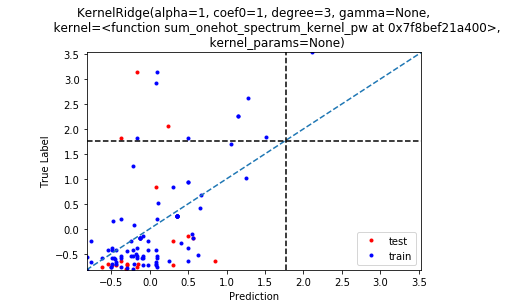

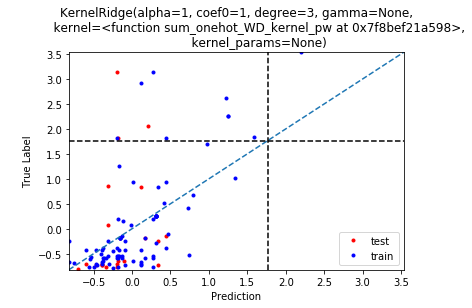

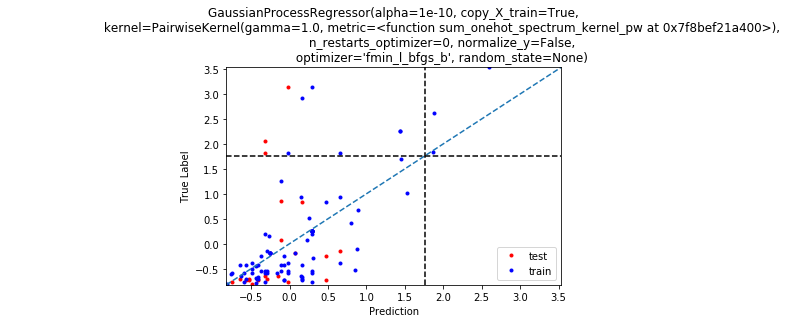

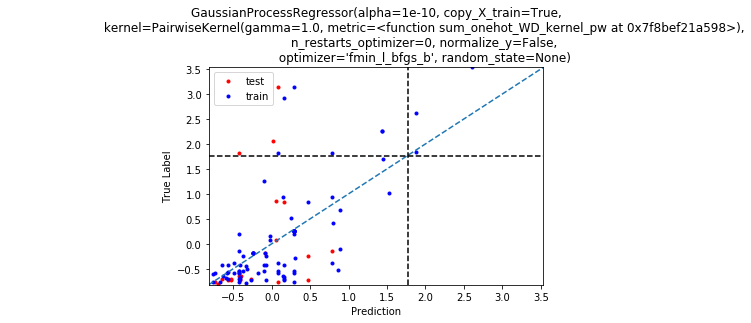

In [9]:
def run_regression(model, kernel, embedding):
    if model == KernelRidge:
        reg = Regression(model(kernel = kernel), data, embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression(model(kernel = PairwiseKernel(metric = kernel)), data, embedding)
    reg.train()
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag)
    key = regression_name[model] + '_' + kernel_name[kernel] + '_' + embedding
    train_scores[key] = train_score
    test_scores[key] = test_score
    print()

for model in [KernelRidge, GaussianProcessRegressor]:
    for kernel in kernels:
        run_regression(model, kernel, 'label')

### Kernel Ridge Regression 

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.17111313826487962
Test RMSE:  0.2447099352212014


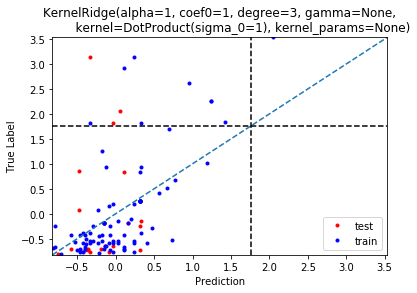

In [10]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['KR_onehot_DP'] = train_score
test_scores['KR_onehot_DP'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.2088117996538546
Test RMSE:  0.2474288132113013


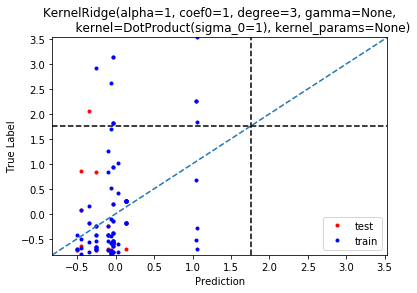

In [11]:
# kmer embedding with DotProduct kernel (l = 3)

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'kmer')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['KR_kmer_DP'] = train_score
test_scores['KR_kmer_DP'] = test_score

### Gaussian Process Regression

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.16743102162287588
Test RMSE:  0.24948571182821874


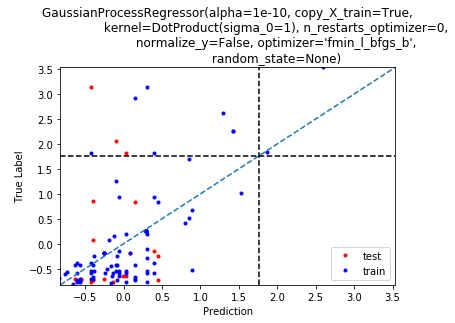

In [12]:
# # baseline: onehot embedding with DotProduct Kernel 
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['GPR_onehot_DP'] = train_score
test_scores['GPR_onehot_DP'] = test_score

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.20870269764752394
Test RMSE:  0.24710543562628598


/home/mengyan/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1097728.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


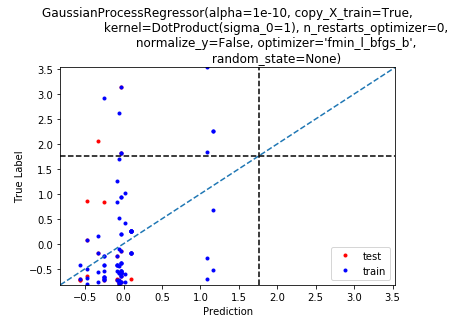

In [13]:
# kmer embedding (l = 3)
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'kmer')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['GPR_kmer_DP'] = train_score
test_scores['GPR_kmer_DP'] = test_score

Text(0.5, 1.0, 'Train Scores')

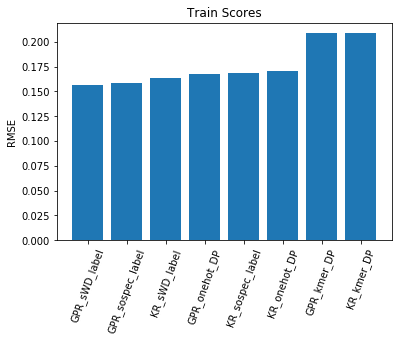

In [14]:
sorted_train_scores = sorted(train_scores.items(), key=lambda kv: kv[1])

import collections

sorted_train_scores = collections.OrderedDict(sorted_train_scores)

plt.bar(range(len(sorted_train_scores)), list(sorted_train_scores.values()), align='center')
plt.xticks(range(len(sorted_train_scores)), list(sorted_train_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Train Scores')

Text(0.5, 1.0, 'Test Scores')

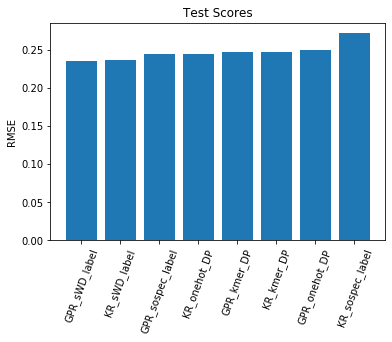

In [15]:
sorted_test_scores = sorted(test_scores.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')

In [16]:
import pickle

#with open('sum_kernels.pickle', 'wb') as handle:
#    pickle.dump(sorted_test_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)